# STARS IN STATS: THE BEST ADVANCED STAT

#### By Kasra Torshizi and Shabarish Nair

### ![alt text](bron.jpg "Title")

### Table of Contents

1. Introduction
2. Data Collection and Parsing
3. Data Management and Representation
4. Exploratory Data Analysis
5. Hypothesis Testing
6. More Exploratory Data Analysis
7. Hypothesis Testing Again
8. Conclusion

# Chapter 1: Introduction

Welcome to the ShabKasra tutorial! Our tutorial is about predicting how many wins an NBA team will get in the regular season based on the performances of their top 5 players in the previous season. The reason we use the top 5 players is that each team can only have 5 players on the court at a time. Players on a team are usually designated by “starters”, who are the players that are placed in the game at the start of the game and are usually the 5 most impactful players on the team, or “bench players”, who are usually the supporting cast who are placed in to allow the starters to rest. In rare circumstances, a team may place one of their better players on the bench but still give them considerable playing time. Two examples of this are Kobe Bryant in the early years of his career and also Tyler Herro, who is a current player on the Miami Heat. 

Many times, people use the sight test to determine how good a player is. By watching a player play for a series of games, it is possible to get a qualitative estimate of a player’s impact. Usually people who are more experienced in the game’s dynamic (ex. Coaches and retired players) provide more quality descriptions of a player’s impact. However, there is a fallacy in that a player’s highlights and lowlights usually get weighted much more than their consistent play as these highlights and lowlights are much more memorable. For example, a thunderous dunk is much more memorable than consistent playmaking. This type of assessment is very common during tryouts and training camps, where quantitative data is not available for a player. 

As a player plays in a series of formal games (in an actual league), that's where it becomes possible to measure and compare players based on quantitative stats. In basketball, the three main statistics are points, assists (when a player passes to a player and that player ends up scoring the ball), and rebounds (getting the ball after a missed shot). These stats provide insights that might be missed by the sight test, especially rebounds as the number rebounds tend to be subtle when spectating a game. 

Even these statistics may be misleading as well. For example, 30 points in a game is generally considered a great performance. However, many players can achieve this by putting up a lot of shots even if they make a lot of misses along that way. These misses are generally considered detrimental to a team’s success as this usually places the ball in the opponent's hands and decreases the shot opportunities of other players. This is where efficiency comes in. A player’s efficiency relates to the percentage of shots that a player makes. A player’s field goal percentage is the number of shots they make divided by the number of shots they take. Thus, 30 points on 65% field goal percentage is much more impactful than 30 points on 35% field goal percentage. Since, shots behind the arc are worth three points instead of two and free throws are worth only 1 point, most pundits use True Shooting Percentage (TS%) which accounts for these points differences. 

There are, on the other hand, so many aspects of a player’s game that could provide impact that aren’t measured properly by these stats alone. For example, a player’s defense (even though steals and blocks are recorded) and setting screens often go unnoticed in counting stats. This is where advanced statistics come in. Most advanced statistics require that the player play over a significant amount of games (such as the course of a season) as most of these statistics aim to see an increase/decrease in a team’s performance when a player is in the game as opposed to when they’re not. The first is a statistic called Win Shares (WS), which estimates the number of wins a player contributed to their team over the course of a season. With this statistic, players that play more games end up getting higher Win Shares even if they are not very impactful. Thus, we produce a statistic called WS/48 which is the number of wins a player contributes per 48 minutes of play. 

Another statistic is called the box plus-minus. This statistic reflects how well a team did when a specific player was on the court. For example, if a player has a plus-minus of +8, that means that the team outscored the opponents by 8 points while they were on the court. The statistic we’re going to look at is BPM, which is a players box plus-minus for every 100 possessions. The final statistic we’re going to look at is Value over Replacement (VORP), which estimates how many points a player contributed towards per 100 possessions over a theoretical replacement player.

Therefore as another part of this project, we aim to see which one of these Advanced Statistics (WS, WS/48, BPM, VROP) is the best indicator of a team’s regular season success with the method first described: sum the top five players’ stats on any given team.

In [993]:
#Libraries/Imports

import requests
import pandas as pd
from bs4 import BeautifulSoup as bs
import numpy as np
from matplotlib import pyplot as plt
from numpy import cov
from sklearn import linear_model
import sklearn.metrics as met
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import statsmodels.api as sm

# Chapter 2: Data Collection and Parsing

The first step to this project is finding an appropriate dataset to work with. Thankfully since basketball analytics is very popular, there are tons of datasets available. Perhaps the most prominent of which is basketball-reference.com. However, this site only presents the data within the website and does not provide external files (ex. A csv or database). Therefore, we have to use web scraping to import the data into our code. To get data about how well a team did in a specific year, we would have scraped the site: “https://www.basketball-reference.com/teams/{Team}/{Year}.html”. The first thought is that we can just put all the team names in a list and query over the years we want. However, there is a slight issue in that there are some teams that have changed names. For example, the Seattle Supersonics changed to the Oklahoma City Thunder in 2018 and the New Jersey Nets changed to the Brooklyn Nets in 2012. So what we’re going to do instead is for each year, we scrape “basketball-reference.com/leagues/NBA_{Year}.html” to get the list of teams that played that year and then add “https://www.basketball-reference.com/teams/{Team}/{Year}.html” to a collective list of links for every team in each year. 

In [994]:
#list for all links
allLinks = []

for year in range(2000,2023):
    url = "https://www.basketball-reference.com/leagues/NBA_{}.html".format(year) # puts year into url
    
    #sending request
    response = requests.request("GET", url).text 
    soupStruct = bs(response)
    
    #finding first two tables which has links on all the teams
    allTables = soupStruct.findAll('table')[:2]
    
    #getting the href tag that will lead to each team's page
    for table in allTables:
        for row in table.find_all('tr'):
            for th in row.find_all('th'):
                aTag = th.a
                if aTag != None:
                    allLinks.append(aTag['href'])

print("Here is an example of 1 of our " + str(len(allLinks)) + " links: " + allLinks[0])

Here is an example of 1 of our 685 links: /teams/MIA/2000.html


Since now we have all of the links we want to query, let’s scrape each of these sites to make one huge collective table with all of the players in all of the years between 2000 - 2020 with their season statistics, team played for, and record for the team they played for. 



In [998]:
scrapedData = pd.DataFrame(data = None, index = None, columns = None, dtype = None, copy = None)

for link in allLinks:
    #creating the link with array with combo of links and years
    url = "https://www.basketball-reference.com" + link
    
    #sending request
    response = requests.request("GET", url).text
    soup = bs(response)
    
    #finding the record by looking for the word "Record:"
    record = soup.find(lambda tag: tag.name == "strong" and "Record:" in tag.text).next_sibling 
    winsLoss = record.split(',')[0].strip().split('-') #looking for wins
    wins = int(winsLoss[0])
    losses = int(winsLoss[1])
    
    #finding the correct table from the team website by looking for keywords "Totals"
    rosterTable = soup.find(lambda tag: tag.name == "h2" and "Advanced" in tag.text).find_next("table")
    
    #converting from html to dataframe
    teamRosterDF = pd.read_html(str(rosterTable))[0]
    
    #adding the year,team, wins, and losses to the dataframe
    teamRosterDF["Year"] = url[-9:-5]
    teamRosterDF["Team"] = url[-13:-10]
    teamRosterDF["Wins"] = wins
    teamRosterDF["Losses"] = losses
    teamRosterDF.rename(columns = {'Unnamed: 1':'Name'}, inplace = True) #renaming the name column
    scrapedData = scrapedData.append(teamRosterDF) #adding to the complete roster data

#deleting rows without a name
scrapedData = scrapedData.dropna(subset=['Name'])

#deleting columns that are empty
del rosterData["Unnamed: 22"]
del rosterData["Unnamed: 17"]

scrapedData

,Rk,Name,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,WS/48,Unnamed: 22,OBPM,DBPM,BPM,VORP,Year,Team,Wins,Losses
0,1,Jamal Mashburn,27,76,2828,15.4,0.526,0.240,0.206,2.8,...,0.109,NaN,0.9,-0.4,0.5,1.8,2000,MIA,52,30
1,2,Alonzo Mourning,29,79,2748,25.8,0.596,0.003,0.492,9.5,...,0.226,NaN,3.1,2.2,5.3,5.0,2000,MIA,52,30
2,3,Dan Majerle,34,69,2308,11.4,0.559,0.720,0.164,1.4,...,0.126,NaN,-0.2,2.1,1.9,2.3,2000,MIA,52,30
3,4,P.J. Brown,30,80,2302,15.3,0.516,0.001,0.237,11.4,...,0.143,NaN,-0.3,0.6,0.3,1.4,2000,MIA,52,30
4,5,Anthony Carter,24,79,1859,11.0,0.442,0.045,0.244,3.1,...,0.036,NaN,-3.0,0.2,-2.7,-0.4,2000,MIA,52,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,15,Daishen Nix,19,24,261,8.1,0.480,0.388,0.448,2.9,...,-0.033,NaN,-5.4,-1.0,-6.4,-0.3,2022,HOU,20,62
15,16,Usman Garuba,19,24,239,12.9,0.510,0.455,0.159,9.6,...,0.105,NaN,-1.8,0.9,-0.9,0.1,2022,HOU,20,62
16,17,Danuel House Jr.,28,16,233,6.8,0.467,0.459,0.257,1.9,...,-0.049,NaN,-4.8,-0.7,-5.6,-0.2,2022,HOU,20,62
17,18,Bruno Fernando,23,10,94,26.5,0.699,0.024,0.463,12.8,...,0.164,NaN,1.3,0.2,1.5,0.1,2022,HOU,20,62


When running the above script, it took a while for it to scrape all of the websites (30 teams * 20 years = 600 websites). Let’s save all of this raw data into a csv instead. 

In [999]:
#resetting the index to go from 0 to n number of rows
scrapedData.reset_index(drop = True,inplace = True)
scrapedData.to_csv("all_player_data.csv", index = False)

rosterData =  pd.read_csv("all_player_data.csv")

rosterData

,Rk,Name,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,WS/48,Unnamed: 22,OBPM,DBPM,BPM,VORP,Year,Team,Wins,Losses
0,1,Jamal Mashburn,27,76,2828,15.4,0.526,0.240,0.206,2.8,...,0.109,NaN,0.9,-0.4,0.5,1.8,2000,MIA,52,30
1,2,Alonzo Mourning,29,79,2748,25.8,0.596,0.003,0.492,9.5,...,0.226,NaN,3.1,2.2,5.3,5.0,2000,MIA,52,30
2,3,Dan Majerle,34,69,2308,11.4,0.559,0.720,0.164,1.4,...,0.126,NaN,-0.2,2.1,1.9,2.3,2000,MIA,52,30
3,4,P.J. Brown,30,80,2302,15.3,0.516,0.001,0.237,11.4,...,0.143,NaN,-0.3,0.6,0.3,1.4,2000,MIA,52,30
4,5,Anthony Carter,24,79,1859,11.0,0.442,0.045,0.244,3.1,...,0.036,NaN,-3.0,0.2,-2.7,-0.4,2000,MIA,52,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,15,Daishen Nix,19,24,261,8.1,0.480,0.388,0.448,2.9,...,-0.033,NaN,-5.4,-1.0,-6.4,-0.3,2022,HOU,20,62
12408,16,Usman Garuba,19,24,239,12.9,0.510,0.455,0.159,9.6,...,0.105,NaN,-1.8,0.9,-0.9,0.1,2022,HOU,20,62
12409,17,Danuel House Jr.,28,16,233,6.8,0.467,0.459,0.257,1.9,...,-0.049,NaN,-4.8,-0.7,-5.6,-0.2,2022,HOU,20,62
12410,18,Bruno Fernando,23,10,94,26.5,0.699,0.024,0.463,12.8,...,0.164,NaN,1.3,0.2,1.5,0.1,2022,HOU,20,62


# Chapter 3: Data Management and Representation

Now let’s add a few columns to our dataframe; since we are trying to use a player’s statistics in the previous season to predict a team’s win percentage, let’s add that for each player. We run into an issue where rookies don’t have data for their previous season as it is their first season in the league. Although most of the time, rookies are not necessarily impactful on an NBA team due to their lack of experience, sometimes they become the most invaluable player on a roster such as Shaquille O’Neal in 1996 or Lebron James in 2003. A possible idea was to use a player’s college statistics in this calculation. However, since the competition in college is a fair share worse, those stats are not very indicative of performance in the NBA. Thus, we will just discard rookies by giving them extremely low statistics for the previous season (so they will filter to the bottom when we sort for the five best players on a team which is equivalent to discarding them). 

In [1000]:
#creating new columns for our dataframe
rosterData["Previous TS%"] = 0
rosterData["Previous TRB%"] = 0
rosterData["Previous AST%"] = 0
rosterData["Previous BPM"] = 0
rosterData["Previous VORP"] = 0
rosterData["Previous WS"] = 0
rosterData["Previous WS/48"] = 0
rosterData["Rookie"] = False

#trying to find player within the 3 years before(accounts for injuries)
#getting previous information and adding to current year column
for index, row in rosterData.iterrows():
    currentYear = row["Year"]
    previousYear = currentYear - 1
    name = row["Name"]
    
    #skipping all players in 2000 season because there are no seasons in the DF before that one
    if currentYear == 2000:
        rosterData.loc[index,"Previous TS%"] = np.nan
        rosterData.loc[index,"Previous TRB%"] = np.nan
        rosterData.loc[index,"Previous AST%"] = np.nan
        rosterData.loc[index,"Previous BPM"] = np.nan
        rosterData.loc[index,"Previous VORP"] = np.nan
        rosterData.loc[index,"Previous WS"] = np.nan
        rosterData.loc[index,"Previous WS/48"] = np.nan
        rosterData.loc[index,"Rookie"] = np.nan
        continue
    
    #finding player in the dataframe
    prevYearRow = rosterData.loc[(rosterData["Name"] == name) & (rosterData["Year"] == previousYear)]
    if len(prevYearRow) == 0:
        #checks 2 years before if not in 1 year before
        prevYearRow = rosterData.loc[(rosterData["Name"] == name) & (rosterData["Year"] == previousYear - 1)]
        if (len(prevYearRow) == 0):
            #checks 3 years befoer if not in 1 year before or 2 years before
            prevYearRow = rosterData.loc[(rosterData["Name"] == name) & (rosterData["Year"] == previousYear - 2)]
            if (len(prevYearRow) == 0):
                #if not within past 3 years, we assume its a rookie
                rosterData.loc[index,"Rookie"] = True
    
    #if the player was on multiple teams, we take the row/team where he played the most games
    if len(prevYearRow) > 1:
        prevYearRow = rosterData[rosterData.index == prevYearRow["G"].idxmax()]
        
    #setting columns to previous year data if not a rookie
    if (rosterData.loc[index,"Rookie"] != True):
        rosterData.loc[index,"Rookie"] = False
        rosterData.loc[index,"Previous TS%"] = float(prevYearRow["TS%"])
        rosterData.loc[index,"Previous TRB%"] = float(prevYearRow["TRB%"])
        rosterData.loc[index,"Previous AST%"] = float(prevYearRow["AST%"])
        rosterData.loc[index,"Previous BPM"] = float(prevYearRow["BPM"])
        rosterData.loc[index,"Previous VORP"] = float(prevYearRow["VORP"])
        rosterData.loc[index,"Previous WS"] = float(prevYearRow["WS"])
        rosterData.loc[index,"Previous WS/48"] = float(prevYearRow["WS/48"])
    else:
        #making all stats -50 for rookies to skip them in the later steps
        rosterData.loc[index,"Previous TS%"] = -50
        rosterData.loc[index,"Previous TRB%"] = -50
        rosterData.loc[index,"Previous AST%"] = -50
        rosterData.loc[index,"Previous BPM"] = -50
        rosterData.loc[index,"Previous VORP"] = -50
        rosterData.loc[index,"Previous WS"] = -50
        rosterData.loc[index,"Previous WS/48"] = -50

rosterData

,Rk,Name,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,Wins,Losses,Previous TS%,Previous TRB%,Previous AST%,Previous BPM,Previous VORP,Previous WS,Previous WS/48,Rookie
0,1,Jamal Mashburn,27,76,2828,15.4,0.526,0.240,0.206,2.8,...,52,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Alonzo Mourning,29,79,2748,25.8,0.596,0.003,0.492,9.5,...,52,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Dan Majerle,34,69,2308,11.4,0.559,0.720,0.164,1.4,...,52,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,P.J. Brown,30,80,2302,15.3,0.516,0.001,0.237,11.4,...,52,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Anthony Carter,24,79,1859,11.0,0.442,0.045,0.244,3.1,...,52,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,15,Daishen Nix,19,24,261,8.1,0.480,0.388,0.448,2.9,...,20,62,-50.000,-50.0,-50.0,-50.0,-50.0,-50.0,-50.000,True
12408,16,Usman Garuba,19,24,239,12.9,0.510,0.455,0.159,9.6,...,20,62,-50.000,-50.0,-50.0,-50.0,-50.0,-50.0,-50.000,True
12409,17,Danuel House Jr.,28,16,233,6.8,0.467,0.459,0.257,1.9,...,20,62,0.525,7.5,10.6,-3.5,-0.3,0.5,0.026,False
12410,18,Bruno Fernando,23,10,94,26.5,0.699,0.024,0.463,12.8,...,20,62,0.475,18.9,5.8,-6.5,-0.3,-0.1,-0.019,False


Now let’s add some more columns that say how each player ranked among their own team for each statistic. 

In [1001]:
#grouping by year and team, then ranking that player along each team for each advanced stat

for previousStat in ['Previous VORP','Previous TS%','Previous TRB%','Previous AST%','Previous BPM', "Previous VORP", "Previous WS", "Previous WS/48"]:
    rosterData[f'{previousStat} Team Rank'] = rosterData.groupby(["Year","Team"])[previousStat].rank(ascending = False,method = 'first',na_option = "top")

rosterData

,Rk,Name,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,Previous WS,Previous WS/48,Rookie,Previous VORP Team Rank,Previous TS% Team Rank,Previous TRB% Team Rank,Previous AST% Team Rank,Previous BPM Team Rank,Previous WS Team Rank,Previous WS/48 Team Rank
0,1,Jamal Mashburn,27,76,2828,15.4,0.526,0.240,0.206,2.8,...,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,Alonzo Mourning,29,79,2748,25.8,0.596,0.003,0.492,9.5,...,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,3,Dan Majerle,34,69,2308,11.4,0.559,0.720,0.164,1.4,...,NaN,NaN,NaN,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4,P.J. Brown,30,80,2302,15.3,0.516,0.001,0.237,11.4,...,NaN,NaN,NaN,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,5,Anthony Carter,24,79,1859,11.0,0.442,0.045,0.244,3.1,...,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,15,Daishen Nix,19,24,261,8.1,0.480,0.388,0.448,2.9,...,-50.0,-50.000,True,17.0,17.0,17.0,17.0,17.0,17.0,17.0
12408,16,Usman Garuba,19,24,239,12.9,0.510,0.455,0.159,9.6,...,-50.0,-50.000,True,18.0,18.0,18.0,18.0,18.0,18.0,18.0
12409,17,Danuel House Jr.,28,16,233,6.8,0.467,0.459,0.257,1.9,...,0.5,0.026,False,12.0,12.0,7.0,6.0,12.0,10.0,11.0
12410,18,Bruno Fernando,23,10,94,26.5,0.699,0.024,0.463,12.8,...,-0.1,-0.019,False,13.0,13.0,1.0,12.0,13.0,13.0,13.0


From here, we can easily just add more columns to see if each player was within the top 5 players on the team for each statistic. 

In [1002]:
#adding a column to check if they are a top 5 player within their own team
for previousStat in ['Previous VORP','Previous TS%','Previous TRB%','Previous AST%','Previous BPM', "Previous WS", "Previous WS/48"]:
    rosterData[f'Top 5 {previousStat} Team Rank'] = False
    rosterData.loc[rosterData[f'{previousStat} Team Rank'] <= 5, f'Top 5 {previousStat} Team Rank'] = True
rosterData

,Rk,Name,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,Previous BPM Team Rank,Previous WS Team Rank,Previous WS/48 Team Rank,Top 5 Previous VORP Team Rank,Top 5 Previous TS% Team Rank,Top 5 Previous TRB% Team Rank,Top 5 Previous AST% Team Rank,Top 5 Previous BPM Team Rank,Top 5 Previous WS Team Rank,Top 5 Previous WS/48 Team Rank
0,1,Jamal Mashburn,27,76,2828,15.4,0.526,0.240,0.206,2.8,...,1.0,1.0,1.0,True,True,True,True,True,True,True
1,2,Alonzo Mourning,29,79,2748,25.8,0.596,0.003,0.492,9.5,...,2.0,2.0,2.0,True,True,True,True,True,True,True
2,3,Dan Majerle,34,69,2308,11.4,0.559,0.720,0.164,1.4,...,3.0,3.0,3.0,True,True,True,True,True,True,True
3,4,P.J. Brown,30,80,2302,15.3,0.516,0.001,0.237,11.4,...,4.0,4.0,4.0,True,True,True,True,True,True,True
4,5,Anthony Carter,24,79,1859,11.0,0.442,0.045,0.244,3.1,...,5.0,5.0,5.0,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12407,15,Daishen Nix,19,24,261,8.1,0.480,0.388,0.448,2.9,...,17.0,17.0,17.0,False,False,False,False,False,False,False
12408,16,Usman Garuba,19,24,239,12.9,0.510,0.455,0.159,9.6,...,18.0,18.0,18.0,False,False,False,False,False,False,False
12409,17,Danuel House Jr.,28,16,233,6.8,0.467,0.459,0.257,1.9,...,12.0,10.0,11.0,False,False,False,False,False,False,False
12410,18,Bruno Fernando,23,10,94,26.5,0.699,0.024,0.463,12.8,...,13.0,13.0,13.0,False,False,True,False,False,False,False


Now this is where we group all this player data into a more general table for each team/season. For each team/season, we’re going to find the average value for each statistic for the top 5 players in the team for that one statistic. 

In [1003]:
#creating a new dataframe, starting by adding Previous VORP column with teams and year columns
teamStats = rosterData.groupby(['Year','Team','Top 5 Previous VORP Team Rank'], as_index = False)['Previous VORP'].mean()

#adding rest of advanced stats to the teamStats dataframe
for previousStat in ['TS%','TRB%','AST%','BPM', "WS", "WS/48"]:
    eachStatSeries = rosterData.groupby(['Year','Team',f'Top 5 Previous {previousStat} Team Rank'])["Previous " + previousStat].mean()
    teamStats["Mean "+ previousStat] = eachStatSeries.reset_index(drop = True)

#adding wins, losses, Total Games, Win %, and other formatting adjustments
wins = rosterData.groupby(['Year','Team',f'Top 5 Previous VORP Team Rank'])["Wins"].agg(pd.Series.mode)
losses = rosterData.groupby(['Year','Team',f'Top 5 Previous VORP Team Rank'])["Losses"].agg(pd.Series.mode)
teamStats["Wins"] = wins.reset_index(drop = True)
teamStats["Losses"] = losses.reset_index(drop = True)
teamStats["Total Games"] = teamStats["Wins"] + teamStats["Losses"]
teamStats["Win %"] = teamStats["Wins"]/teamStats["Total Games"]
teamStats["Mean TS%"] = teamStats["Mean TS%"] * 100

#renaming columns and more formatting
teamStats.rename(columns={"Previous VORP": "Mean VORP","Top 5 Previous VORP Team Rank":"With Top 5 Players"}, inplace = True)
teamStats = teamStats[teamStats["With Top 5 Players"]]
teamStats.reset_index(drop = True,inplace = True)

teamStats

,Year,Team,With Top 5 Players,Mean VORP,Mean TS%,Mean TRB%,Mean AST%,Mean BPM,Mean WS,Mean WS/48,Wins,Losses,Total Games,Win %
0,2000,ATL,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,54,82,0.341463
1,2000,BOS,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,47,82,0.426829
2,2000,CHH,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,33,82,0.597561
3,2000,CHI,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,65,82,0.207317
4,2000,CLE,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,50,82,0.390244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
680,2022,SAC,True,1.82,64.60,17.66,24.22,2.66,5.06,0.1506,30,52,82,0.365854
681,2022,SAS,True,1.30,62.20,15.56,23.80,1.24,4.24,0.1390,34,48,82,0.414634
682,2022,TOR,True,1.80,58.94,15.30,27.50,2.22,4.56,0.1334,48,34,82,0.585366
683,2022,UTA,True,2.70,66.38,18.54,23.30,4.02,7.24,0.1962,49,33,82,0.597561


This is where we start doing some exploratory analysis to better understand our data. Although a lot of these projections may not directly relate to what we’re looking for, they can show us trends that we may have not suspected exist (which can provide points for further analysis). Since we're just starting our exploratory analysis, we want to remove any rows that won't help us in this stage. As a result we removed any rows from the 1999-2000 season. This season has no previous data for the players because the actual data started from the 1999-2000 season as well.

In [1004]:
#getting rid of players and teams in the 1999-2000 season

rosterData = rosterData[rosterData['Year'] != 2000]
rosterData = rosterData.reset_index(drop = True)

teamStats = teamStats[teamStats['Year'] != 2000]
teamStats = teamStats.reset_index(drop = True)

Again, we converted the dataframes to csv. Processing these steps to create the dataframe can take a substantial amount of time. In any case we need to restart, we can directly extract the data from the csv. 

In [1005]:
rosterData.to_csv("Refined Roster Data.csv", index = False)
teamStats.to_csv("Team Stats Data.csv", index = False)

# Chapter 4: Exploratory Data Analysis

First we really wanted to see any basic correlation between the statistics and win percentage. We were also very intrigued by how these stats held up in recent years, so we created a scatter plot that had the advanced statistic on the x-axis and winning percentage on the y-axis. Initially we did have the graphs for every year of the data presented. However, there were 147 combinations of years and statistics. We still wanted to see the statistics over time, so we decided to pick 2 years to cover the discrepancy over time, the first season and the last season. 

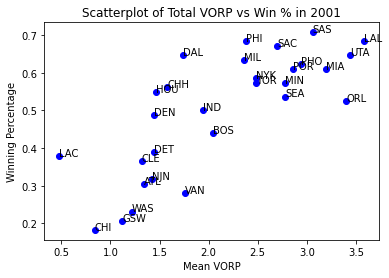

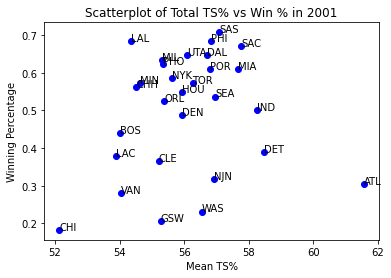

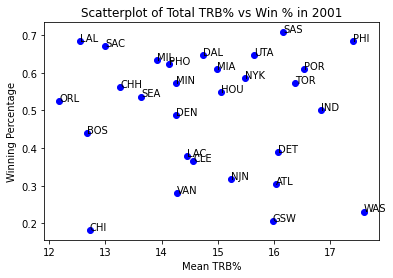

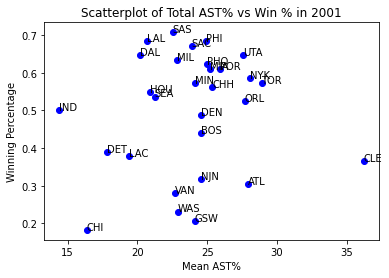

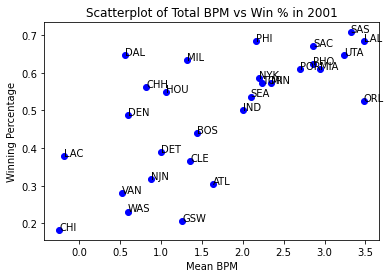

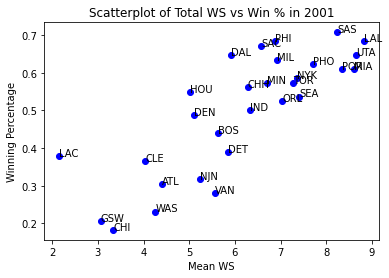

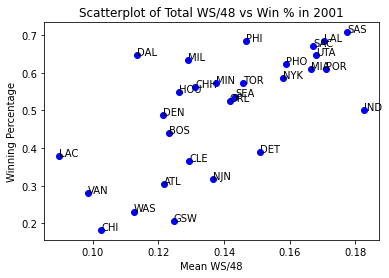

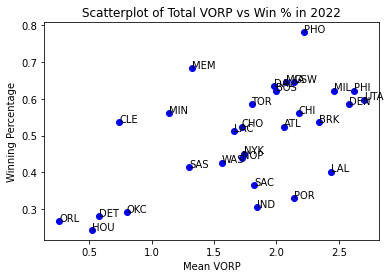

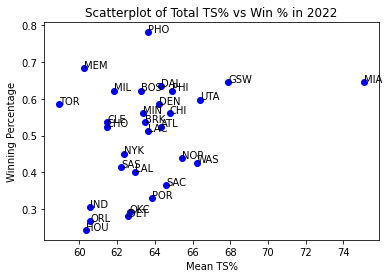

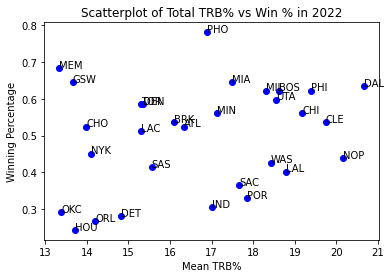

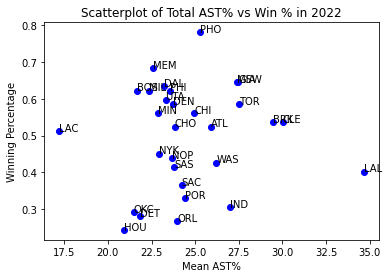

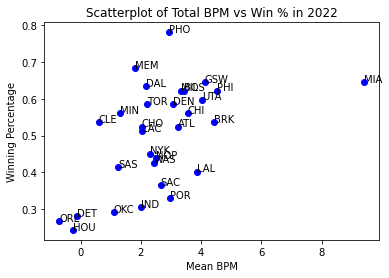

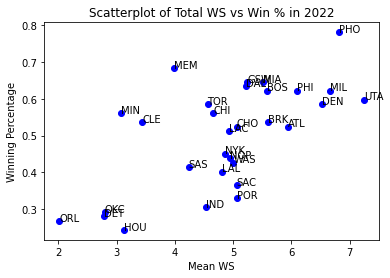

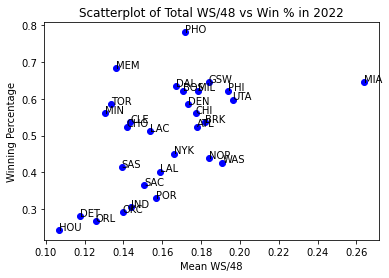

In [1006]:

#list of advanced stats for easy use
advStats = ['VORP','TS%','TRB%','AST%','BPM', "WS", "WS/48"]

groupedYear = teamStats.groupby('Year')

#getting all advanced stats in a scatter plot for 2001 and 2022
#grouping by year to view data from each team
for key, item in groupedYear:
    #only need data from 2001 and 2022, otherwise you get 147 different graphs
    if key != 2001 and key != 2022:
        continue
    
    #going through all advanced stats columns
    yearDF = groupedYear.get_group(key)
    for stat in advStats:
        #setting x and y axis of scatterplot
        xAxis = yearDF["Mean " + stat].reset_index(drop=True)
        yAxis = yearDF["Win %"].reset_index(drop=True)
        
        #labelling and plotting
        plt.figure()
        plt.scatter(x = xAxis, y = yAxis, color = 'b')
        plt.xlabel("Mean " + stat)
        plt.ylabel("Winning Percentage")
        plt.title("Scatterplot of Total " + stat + " vs Win % in " + str(key)) 

        #putting name of teams next to points
        for i, txt in enumerate(yearDF["Team"]):
            plt.annotate(txt, (xAxis[i], yAxis[i]))
        
        #plotting
        plt.plot()
        plt.show()

Right off the bat, we saw relationships between VORP and win%, BPM and win%, WS and win%, and WS/48 and win%. In either year, TRB% and AST% did not look like it had any strong relationship with win%. TS% did look somewhat correlated, but it wasn’t strong enough to say highly correlated. The scatterplots showed us some visual hints, but we decided we needed more numeric confirmation. 

In [1007]:
#printing correlation coefficients for every advanced stat in 2001 and 2022
for year, item in groupedYear:
    if year != 2001 and year != 2022:
        continue
        
    print("Correlation coefficients for stats vs win % in " + str(year) + ':\n')
    
    yearDF = groupedYear.get_group(year)
    for stat in advStats:
        #getting x and y axis
        xAxis = yearDF["Mean " + stat].reset_index(drop=True)
        yAxis = yearDF["Win %"].reset_index(drop=True)
        
        #finding pearson's correlation coefficient
        corr, _ = pearsonr(xAxis, yAxis)
        print("The correlation coefficient for Mean " + stat + " and win percentage in " + str(year) + ": " + str(corr) + '\n')
    
    print('\n')


Correlation coefficients for stats vs win % in 2001:

The correlation coefficient for Mean VORP and win percentage in 2001: 0.7670687598387546

The correlation coefficient for Mean TS% and win percentage in 2001: 0.13780026603913365

The correlation coefficient for Mean TRB% and win percentage in 2001: -0.07118155562533313

The correlation coefficient for Mean AST% and win percentage in 2001: 0.09774408303978224

The correlation coefficient for Mean BPM and win percentage in 2001: 0.684826105842851

The correlation coefficient for Mean WS and win percentage in 2001: 0.8158232209939198

The correlation coefficient for Mean WS/48 and win percentage in 2001: 0.662924944916333



Correlation coefficients for stats vs win % in 2022:

The correlation coefficient for Mean VORP and win percentage in 2022: 0.5824471311213231

The correlation coefficient for Mean TS% and win percentage in 2022: 0.32015618020187087

The correlation coefficient for Mean TRB% and win percentage in 2022: 0.249650497

Next, we looked at the correlation coefficients for the same scatterplots. Remember, correlation coefficients show how closely the points are to each other. If there was a line of best fit, then the correlation coefficient shows how close those points were to the line of best fit and “quantifies the strength of the linear relationship between two variables”. In 2001, the stats that best correlated with win percentage were WS, VORP, BPM, and WS/48 In 2022, the stats that best correlated with better winning percentages were WS, VORP, WS/48, BPM, and WS/48. We can see that the same statistics are better correlated with the data. However, we can also see that these statistics also correlated with win percentage less over time. In 2001, WS had a very high correlation of 0.81, but this decreased to .64 in 2022. A similar trend followed with VORP, BPM, and WS/48. An interesting point that occurred is that TS% and TRB% had the correlation coefficient increase tremendously. TS%’s coefficient increased by .19. TRB%’s coefficient increased by .31. In fact, TRB% negatively correlated with winning percentage in 2001, so it saw a big increase. The outlier of a negative correlation may have been due to a lack of data points.

We can make a guess that shooting has become way more important to winning in today’s game and can better predict team records. We can also assume that teams that have better rebound percentages also correlate to winning more. 

# Chapter 5: Hypothesis Testing

We decided to get right down to the main problem at hand: finding the best statistic at predicting a team’s regular season record. To do this we decided to start testing our hypothesis.

Just off visuals, we believed that VORP, WS, BPM, and WS/48 would best find the winning percentages. Now let’s make our hypothesis test for each statistic.

##### VORP Hypothesis:

Ho: The population correlation coefficient between VORP and team winning percentages is not significantly different from zero. 

Ha: The population correlation coefficient between VORP and team winning percentages is significantly different from zero. 


##### TS% Hypothesis:

Ho: The population correlation coefficient between TS% and team winning percentages is not significantly different from zero. 

Ha: The population correlation coefficient between TS% and team winning percentages is significantly different from zero. 


##### TRB% Hypothesis:

Ho: The population correlation coefficient between TRB% and team winning percentages is not significantly different from zero.

Ha: The population correlation coefficient between TRB% and team winning percentages is significantly different from zero. 


##### AST% Hypothesis:

Ho: The population correlation coefficient between AST% and team winning percentages is not significantly different from zero. 

Ha: The population correlation coefficient between AST% and team winning percentages is significantly different from zero. 


###### BPM Hypothesis:

Ho: The population correlation coefficient between BPM and team winning percentages is not significantly different from zero. 

Ha: The population correlation coefficient between BPM and team winning percentages is significantly different from zero. 


###### WS Hypothesis:

Ho: The population correlation coefficient between WS and team winning percentages is not significantly different from zero. 

Ha: The population correlation coefficient between WS and team winning percentages is significantly different from zero. 


###### WS/48 Hypothesis:

Ho: The population correlation coefficient between WS/48 and team winning percentages is not significantly different from zero.

Ha: The population correlation coefficient between WS/48 and team winning percentages is significantly different from zero. 

Our alpha = 0.05 as this is the standard and it will accommodate our data as well.

### MACHINE LEARNING - Linear Regression

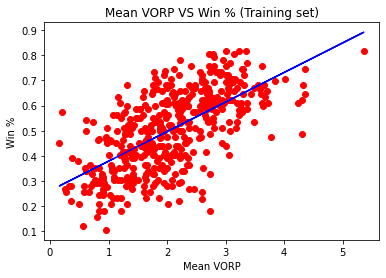

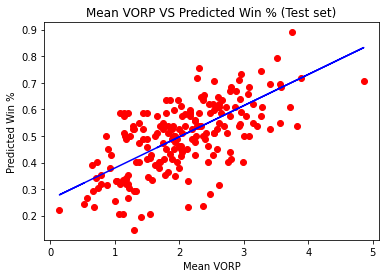

Accuracy of VORP model: 40.769228823531925%
p-value of VORPmodel: 7.051731211104084e-55


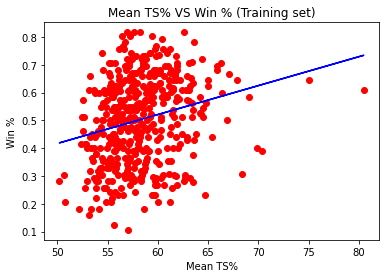

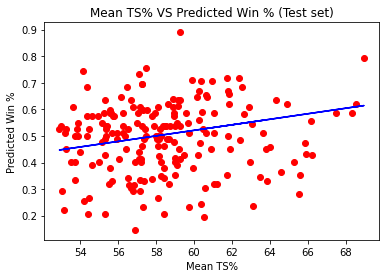

Accuracy of TS% model: -2.3310180928856283%
p-value of TS%model: 3.7217652967183217e-07


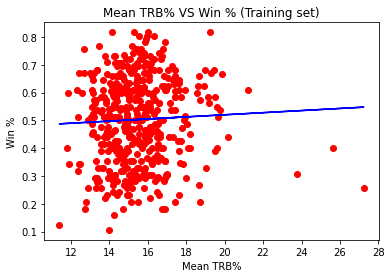

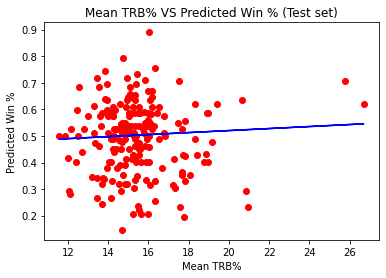

Accuracy of TRB% model: -0.8347837556553106%
p-value of TRB%model: 0.35411133867527256


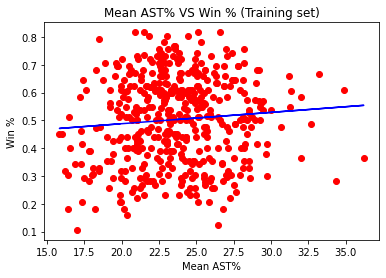

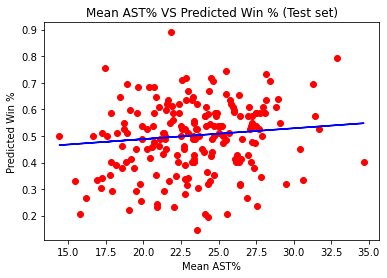

Accuracy of AST% model: 2.317529743224833%
p-value of AST%model: 0.06267773433824464


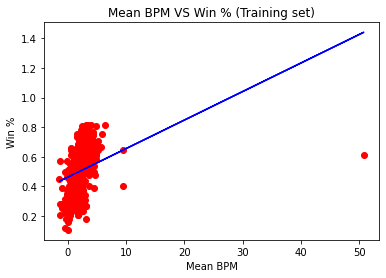

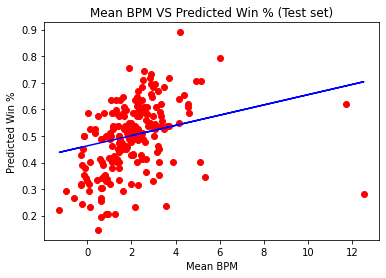

Accuracy of BPM model: 12.44065943038729%
p-value of BPMmodel: 3.161565641503648e-13


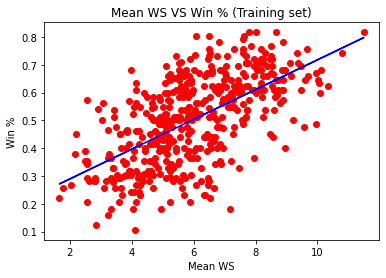

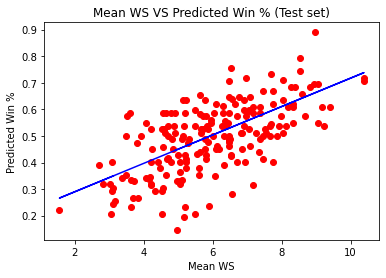

Accuracy of WS model: 40.59160863510615%
p-value of WSmodel: 5.215306612355555e-49


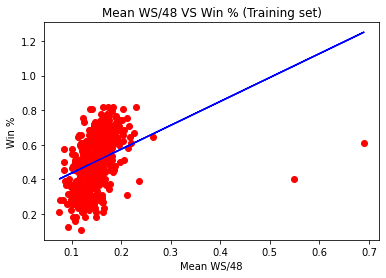

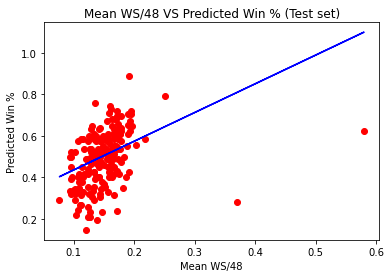

Accuracy of WS/48 model: 8.716023134491891%
p-value of WS/48model: 3.034983999857896e-17


In [1008]:
#all advanced stats in a list for ease of use
advStats = ['VORP','TS%','TRB%','AST%','BPM', "WS", "WS/48"]

#setting all regressors to none for future use
vorpRegressor = None
tsRegressor = None
trbRegressor = None
astRegressor = None
bpmRegressor = None
wsRegressor = None
ws48Regressor = None

#pvalues and accuracies list for later use
pValues = []
accuracies = []

#going through all advanced stats. making two graphs for each stat(training/testing). 
#each stat scatterplot will consist of data points for every team from every year
for stat in advStats:
    #using linear regression
    regressor = linear_model.LinearRegression()
    
    #setting x and y axis
    X = teamStats["Mean " + stat]
    y = teamStats["Win %"]
    
    #splitting into testing and training set. making the testing set 30% of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #reshaping for fit/predict functions
    X_train= X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    
    #getting the model
    regressor.fit(X_train, y_train)
    
    #getting p-value
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    pValues.append(est2.pvalues[1])
    
    #plotting the model on the training data
    plt_train = plt
    plt_train.scatter(X_train, y_train, color='red')
    plt_train.plot(X_train, regressor.predict(X_train), color='blue')
    plt_train.title('Mean '+ stat + ' VS Win % (Training set)')
    plt_train.xlabel('Mean ' + stat)
    plt_train.ylabel('Win %')
    plt_train.show()
    
    #plotting the model on the testing data
    plt_test = plt
    plt_test.scatter(X_test, y_test, color='red')
    plt_test.plot(X_test, regressor.predict(X_test), color='blue')
    plt_test.title('Mean '+ stat + ' VS Predicted Win % (Test set)')
    plt_test.xlabel('Mean ' + stat)
    plt_test.ylabel('Predicted Win %')
    plt_test.show()
    
    #predicting win % based on test set for statistic
    y_pred = regressor.predict(X_test)
    
    #determine accuracy
    accuracy = regressor.score(X_test,y_test)* 100
    accuracies.append(accuracy)
    print("Accuracy of " + stat + " model: " + str(accuracy) + "%")    
    print("p-value of " + stat + "model: " + str(est2.pvalues[1]))
    
    #setting the regressor to the correct variable. depends on stat
    if stat == 'VORP':
       vorpRegressor = regressor
    elif stat == 'TS%':
        tsRegressor = regressor
    elif stat == 'TRB%':
        trbRegressor = regressor
    elif stat == 'AST%':
        astRegressor = regressor
    elif stat == 'BPM':
        bpmRegressor = regressor
    elif stat == 'WS':
        wsRegressor = regressor
    elif stat == 'WS/48':
        ws48Regressor = regressor

Now, what we have is linear regression for each statistic vs win percentage. Why did we choose linear regression? Linear regressions can be used for predictions and have become a reliable way to predict the “future”, which is what the goal of our project is. This project is also looking at qualitative data, which makes linear regression useful(rather than something like decision trees which focuses on attributes). For each advanced stat, we first split up the data into a training set and test set. We chose our split to be 30% because we had so many data points to work with. We used sklearn’s linear regression to fit the data and create the model. In addition, we use statsmodels api package to get the p-value of each model. To make a visualization, we made a scatterplot of each training set vs win % and each testing set vs predicted win %. We also calculated the accuracy of each model on the test set. 

We learned from the model’s that VORP and WS have the best accuracy with getting the win % correct about 40% of the time. BPM and WS/48 have the second best set of accuracies with getting 12% correct and 8% correct respectively. The other stats were not accurate at all. TS% and TRB% actually had negative percentages, meaning they did not correlate with the win % at all

### Determining Hypothesis Results

In [1009]:
#printing out p-values and accuracies found from linear regression
for i, stat in enumerate(advStats):
    print(stat + " model results:")
    print("The p-value for " + stat + " model was " + str(pValues[i]))
    print("The accuracy for " + stat + "model on the test set was " + str(accuracies[i]) + '\n')
    

VORP model results:
The p-value for VORP model was 7.051731211104084e-55
The accuracy for VORPmodel on the test set was 40.769228823531925

TS% model results:
The p-value for TS% model was 3.7217652967183217e-07
The accuracy for TS%model on the test set was -2.3310180928856283

TRB% model results:
The p-value for TRB% model was 0.35411133867527256
The accuracy for TRB%model on the test set was -0.8347837556553106

AST% model results:
The p-value for AST% model was 0.06267773433824464
The accuracy for AST%model on the test set was 2.317529743224833

BPM model results:
The p-value for BPM model was 3.161565641503648e-13
The accuracy for BPMmodel on the test set was 12.44065943038729

WS model results:
The p-value for WS model was 5.215306612355555e-49
The accuracy for WSmodel on the test set was 40.59160863510615

WS/48 model results:
The p-value for WS/48 model was 3.034983999857896e-17
The accuracy for WS/48model on the test set was 8.716023134491891



The p-values were also distributed very similarly to our score. VORP and WS have extremely small p-values with a p-value of 7.051731211104084e-55 and 5.215306612355555e-49 respectively. The next couple models with low p-values include the TS% model, BPM model, and WS/48 model with p-values of 3.7217652967183217e-07, 3.161565641503648e-13, and 3.034983999857896e-17 respectively, The models with the highest p-values were the TSB% model and the AST% model. These models had p-values of 0.35411133867527256 and 0.06267773433824464 respectively. 

As a result, because of the VORP, WS, TS%, BPM, and WS/48 models being significantly lower than our significance level of .05, we can reject the null hypothesis. We can conclude that there is a strong population correlation coefficient between these advanced statistics and team winning percentages. 
However, we will have to fail to reject the null hypothesis for the models for both TRB% and AST%. These models had p-values higher than the significance level. We can conclude that the population correlation between these advanced statistics and win percentage do not exist. 

For now, we can tell that VORP, WS, TS%, BPM, and WS/48 are our best possible models to predict the winning percentage. However, we should go a step further and analyze the accuracies as well. The VORP and WS accuracies are a step above the accuracies of the TS% model, BPM model, and WS/48 model. As a result, we will focus more on VORP and WS.
The fact that our model for these statistics got 40%+ accuracy on the test set means that it got the winning percentage CORRECT based on the statistic alone. This percentage is very high and the extremely small p-values show how ridiculously accurate that these two models are!


# Chapter 6: Some More Exploratory Data Analysis!

### Tutorial Case Study: 2021-2022 NBA Season

Because WS and BPM were so close in p-value and accuracy, we want to look further into these two statistics. To do this, we are going to perform a case study of these two models/statistics on the latest NBA regular season, 2021-2022.

Our case study is going to be determining how well WS and BPM can perform on predicting records of all 30 NBA teams. At the end, we’ll see if we can find which statistic performs better or if there are any trends.

First, we'll add a couple more columns to our old teamStats dataframe and create some new dataframes.

In [1010]:
#getting data on eastern conference teams and western conference teams
easternConference = ['ATL','BOS','BRK','CHI','CHO','CLE','DET','IND','MIA','MIL','NYK','ORL','PHI','TOR','WAS']
westernConference = ['DAL','DEN','GSW','HOU','LAC','LAL','MEM','MIN','NOP','OKC','PHO','POR','SAC','SAS','UTA']

#Using vorp regressor to predict the win percentage and number of wins based on the MEAN VORP of the top 5 players
teamStats["Predicted Win % by VORP"] = vorpRegressor.predict(teamStats["Mean VORP"].values.reshape(-1, 1))
teamStats["Predicted Wins by VORP"] = round(teamStats["Predicted Win % by VORP"] * 82).astype(int)#82 games in a season

#Using win share regressor to predict the win percentage and number of wins based on the MEAN WS of the top 5 players
teamStats["Predicted Win % by WS"] = wsRegressor.predict(teamStats["Mean WS"].values.reshape(-1, 1))
teamStats["Predicted Wins by WS"] = round(teamStats["Predicted Win % by WS"] * 82).astype(int)                                                     

#Calculating residuals for vorp win% and ws win%
teamStats["Residual Vorp Win %"] = teamStats["Win %"] - teamStats["Predicted Win % by VORP"]
teamStats["Residual WS Win %"] = teamStats["Win %"] - teamStats["Predicted Win % by WS"]

#setting conferences to each team according to previous lists
teamStats["Conference"] = "East"
checkWest = [entry in westernConference for entry in teamStats['Team']]
teamStats.loc[checkWest, 'Conference'] = "West"

#rankings teams according to the actual season, the VORP predictions, and the WS predictions
teamStats['Actual Conference Rank'] = teamStats.groupby(["Year","Conference"])["Wins"].rank(ascending = False,method = 'first',na_option = "top").astype(int)
teamStats['Predicted VORP Conference Rank'] = teamStats.groupby(["Year","Conference"])["Predicted Wins by VORP"].rank(ascending = False,method = 'first',na_option = "top").astype(int)
teamStats['Predicted WS Conference Rank'] = teamStats.groupby(["Year","Conference"])["Predicted Wins by WS"].rank(ascending = False,method = 'first',na_option = "top").astype(int)

#only looking at the NBA 2022 Season for a Case Study
season22 = teamStats.loc[teamStats['Year'] == 2022]
season22 = season22.reset_index(drop = True)
season22



,Year,Team,With Top 5 Players,Mean VORP,Mean TS%,Mean TRB%,Mean AST%,Mean BPM,Mean WS,Mean WS/48,...,Predicted Win % by VORP,Predicted Wins by VORP,Predicted Win % by WS,Predicted Wins by WS,Residual Vorp Win %,Residual WS Win %,Conference,Actual Conference Rank,Predicted VORP Conference Rank,Predicted WS Conference Rank
0,2022,ATL,True,2.06,64.340,16.34,25.88,3.24,5.94,0.1778,...,0.503790,41,0.500447,41,0.020600,0.023943,East,9,6,3
1,2022,BOS,True,2.00,63.240,18.62,21.66,3.42,5.58,0.1708,...,0.496745,41,0.481187,39,0.125206,0.140765,East,2,7,5
2,2022,BRK,True,2.34,63.500,16.10,29.46,4.44,5.60,0.1822,...,0.536667,44,0.482257,40,-0.000082,0.054329,East,7,3,4
3,2022,CHI,True,2.18,64.780,19.18,24.94,3.56,4.66,0.1772,...,0.517880,42,0.431964,35,0.043095,0.129011,East,6,4,10
4,2022,CHO,True,1.72,61.440,13.98,23.82,2.04,5.06,0.1418,...,0.463868,38,0.453365,37,0.060523,0.071025,East,10,10,7
5,2022,CLE,True,0.74,61.480,19.74,30.02,0.60,3.44,0.1436,...,0.348797,29,0.366691,30,0.187788,0.169894,East,8,13,13
6,2022,DAL,True,1.98,64.325,20.66,23.22,2.18,5.22,0.1670,...,0.494396,41,0.461926,38,0.139750,0.172221,West,4,7,4
7,2022,DEN,True,2.58,64.200,15.36,23.74,3.08,6.52,0.1730,...,0.564848,46,0.531479,44,0.020518,0.053887,West,6,2,3
8,2022,DET,True,0.58,62.560,14.82,21.86,-0.10,2.78,0.1176,...,0.330010,27,0.331380,27,-0.049522,-0.050892,East,14,14,14
9,2022,GSW,True,2.14,67.900,13.66,27.46,4.12,5.24,0.1840,...,0.513184,42,0.462996,38,0.133158,0.183346,West,3,5,5


We predict the win percentages for each team in each year based on their mean VORP score of the top 5 players and mean WS score of the top 5 players. We also create a column for wins by multiplying the win percentage by 82 and rounding it to the nearest number. Next, we want to get some more analysis done and we find the residual by subtracting the predicted win percentage from the actual win percentage. Lastly, we create a new column to categorize each team into the Eastern conference or Western conference. Currently in the NBA, teams are not ranked by record from the standpoint of the whole league, but they are ranked based on the number of wins they have in their conference. For example, this season the Miami Heat were ranked first in the Eastern conference and the Phoenix Suns were ranked in the Western Conference. Next, we ranked each team among their conference in the year they played and created a column for that. We also used the predicted win columns by each model to see how VORP and WS ranked each team among each conference. Lastly, we’ll create a new dataframe just for the 2021-22 NBA season, so future steps take less time to run.

#### Residuals and Win Percentage

Let's look at the residuals of both models to see how far each model was away from predicting the correct win percentage. 

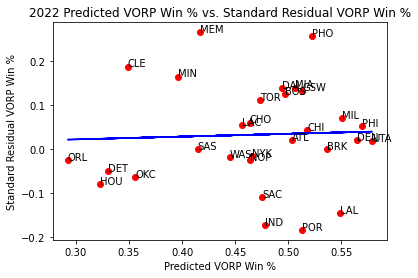

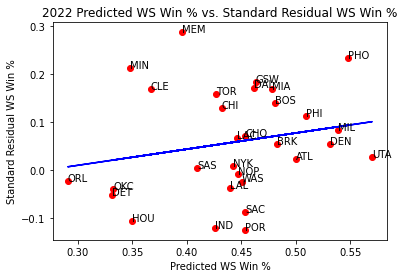

In [1011]:
#creating scatterplot of predicted VORP win% vs residual VORP win%

#setting x and y axis
X = season22["Predicted Win % by VORP"]
y = season22["Residual Vorp Win %"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('2022 Predicted VORP Win % vs. Standard Residual VORP Win %')
plt.xlabel('Predicted VORP Win %')
plt.ylabel('Standard Residual VORP Win %')

#putting name of teams next to points
for i, txt in enumerate(season22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()


#creating scatterplot of predicted WS win% vs residual WS win%

#setting x and y axis 
X = season22["Predicted Win % by WS"]
y = season22["Residual WS Win %"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('2022 Predicted WS Win % vs. Standard Residual WS Win %')
plt.xlabel('Predicted WS Win %')
plt.ylabel('Standard Residual WS Win %')

#putting name of teams next to points
for i, txt in enumerate(season22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()


Let’s first analyze the residual win% for each model and compare it to the predicted win% for each model. For VORP, we see a relatively more flat line near the zero marker. This means that the residuals are very, very small and most of the time, VORP is very close to the actual win percentage. For WS, the line is more slanted. We can see that as the predicted win % increases, the residual does start to increase. This means that WS does get less accurate as it tends to predict higher win percentages. The graphs also show that WS is much more accurate for teams that have a lower win % because of how close the line is to zero in this area.

This last section on model prediction win % vs residuals for each model is very accurate and telling. However, there is a very low probability that these models get the exact winning percentage of teams because of the number of games that are played. This is why we introduced rank. The win % might differ from 2% to 10% and the model might think this is incorrect. However, this predicted win % might still result in the team landing in the same rank as the conference. This is why we initially created the wins column, conference column, and conference rank columns. Giving the models the benefit of the doubt that they are close, let’s see how close VORP and WS get to predicting the exact ranking for both conferences in the 2021-22 NBA season. 


First, we’ll create an eastern conference and western conference dataframe, so it is easier to sort based on ranks within the dataframes. 

In [1012]:
#creating eastern rankings by sorting season22 by conference
easternRankings22 = season22.loc[(season22["Conference"] == 'East')]

#only need these specific columns
easternRankings22 = easternRankings22[['Year','Team','Actual Conference Rank','Predicted VORP Conference Rank','Predicted WS Conference Rank']]

#sorting based on actual rank to get decent visual understanding
easternRankings22 = easternRankings22.sort_values('Actual Conference Rank').reset_index(drop = True)
easternRankings22

,Year,Team,Actual Conference Rank,Predicted VORP Conference Rank,Predicted WS Conference Rank
0,2022,MIA,1,5,6
1,2022,BOS,2,7,5
2,2022,MIL,3,2,1
3,2022,PHI,4,1,2
4,2022,TOR,5,9,12
5,2022,CHI,6,4,10
6,2022,BRK,7,3,4
7,2022,CLE,8,13,13
8,2022,ATL,9,6,3
9,2022,CHO,10,10,7


In [1013]:
#creating western rankings by sorting season22 by conference
westernRankings22 = season22.loc[(season22["Conference"] == 'West')]

#only need these specific columns
westernRankings22 = westernRankings22[['Year','Team','Actual Conference Rank','Predicted VORP Conference Rank','Predicted WS Conference Rank']]

#sorting based on actual rank to get decent visual understanding
westernRankings22 = westernRankings22.sort_values('Actual Conference Rank').reset_index(drop = True)
westernRankings22

,Year,Team,Actual Conference Rank,Predicted VORP Conference Rank,Predicted WS Conference Rank
0,2022,PHO,1,4,2
1,2022,MEM,2,11,12
2,2022,GSW,3,5,5
3,2022,DAL,4,7,4
4,2022,UTA,5,1,1
5,2022,DEN,6,2,3
6,2022,MIN,7,13,14
7,2022,LAC,8,10,6
8,2022,NOP,9,9,7
9,2022,SAS,10,12,11


#### Model Prediction Ranks vs Actual Ranks

Now, we’ll take a look at the predicted VORP and WS rank vs the actual conference rank for both eastern conference and western conference.

###### Eastern Conference

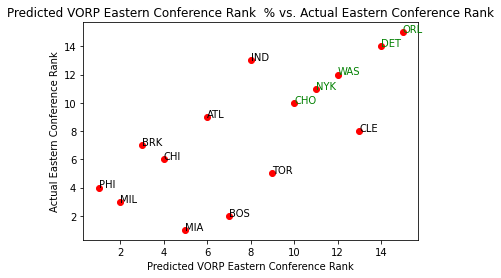

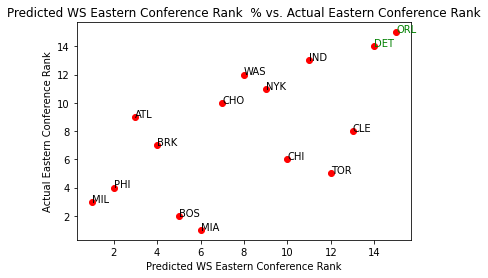

In [1014]:
#creating scatterplot of predicted VORP rank vs actual rank for Eastern Conference

#setting x and y axis 
X = easternRankings22["Predicted VORP Conference Rank"]
y = easternRankings22["Actual Conference Rank"]

#plotting and labelling
plt.scatter(X, y, color='red')
plt.title('Predicted VORP Eastern Conference Rank  % vs. Actual Eastern Conference Rank')
plt.xlabel('Predicted VORP Eastern Conference Rank')
plt.ylabel('Actual Eastern Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(easternRankings22["Team"]):
    if X[i] == y[i]:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

#creating scatterplot of predicted WS rank vs actual rank for Eastern Conference
X = easternRankings22["Predicted WS Conference Rank"]
y = easternRankings22["Actual Conference Rank"]

#plotting and labelling
plt.scatter(X, y, color='red')
plt.title('Predicted WS Eastern Conference Rank  % vs. Actual Eastern Conference Rank')
plt.xlabel('Predicted WS Eastern Conference Rank')
plt.ylabel('Actual Eastern Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(easternRankings22["Team"]):
    if X[i] == y[i]:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

For the eastern conference, we can see that VORP correctly predicted the rank of 5 of the 15 teams and WS correctly predicted the rank of 2 of the 15 teams!

###### Western Conference

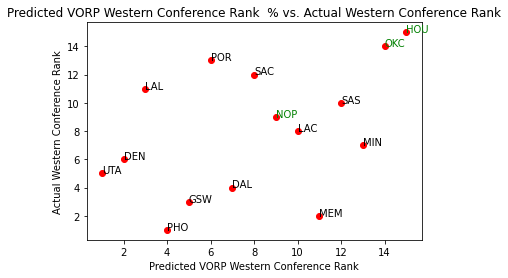

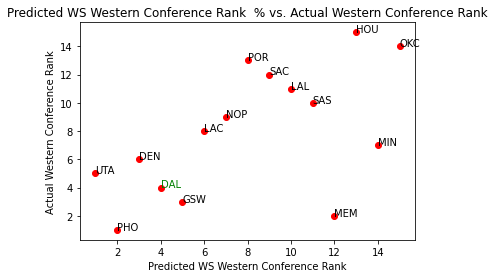

In [1015]:
#creating scatterplot of predicted VORP rank vs actual rank for Western Conference

#setting x and y axis
X = westernRankings22["Predicted VORP Conference Rank"]
y = westernRankings22["Actual Conference Rank"]

#plotting and labelling
plt.scatter(X, y, color='red')
plt.title('Predicted VORP Western Conference Rank  % vs. Actual Western Conference Rank')
plt.xlabel('Predicted VORP Western Conference Rank')
plt.ylabel('Actual Western Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(westernRankings22["Team"]):
    if X[i] == y[i]:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()


#creating scatterplot of predicted WS rank vs actual rank for Western Conference

#setting x and y axis
X = westernRankings22["Predicted WS Conference Rank"]
y = westernRankings22["Actual Conference Rank"]

#plotting and labelling
plt.scatter(X, y, color='red')
plt.title('Predicted WS Western Conference Rank  % vs. Actual Western Conference Rank')
plt.xlabel('Predicted WS Western Conference Rank')
plt.ylabel('Actual Western Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(westernRankings22["Team"]):
    if X[i] == y[i]:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

For the western conference, we can see that VORP correctly predicted the rank of 3 of the 15 teams and WS correctly predicted the rank of 1 of the 15 teams!

So now we are finally getting both models to output the correct rank for some teams. Giving some leeway from giving the exact number of wins(winning percentage) to just seeing rank among all teams found some success for both models. However, there is a clear visible difference in that VORP correctly predicted more teams in both conferences. 

#### Back to Residuals Again


We are using residuals a whole lot! Residuals are a great way to see how close we were to predicting the actual results. VORP might have predicted more teams correctly, but WS might have been closer overall to predicting teams that VORP did not predict correctly. WS might have also been extremely close to predicting the rankings of the team that VORP did get correctly. Let’s check that!


Now, we are focusing on the ranking residuals and seeing how close each model was to predicting the actual rank. We made columns for residual rank for both models in both conferences first.

In [1016]:
#finding residuals in the east coast
easternRankings22['Residual VORP Rank'] = easternRankings22['Actual Conference Rank'] - easternRankings22['Predicted VORP Conference Rank']
easternRankings22['Residual WS Rank'] = easternRankings22['Actual Conference Rank'] - easternRankings22['Predicted WS Conference Rank']
easternRankings22



,Year,Team,Actual Conference Rank,Predicted VORP Conference Rank,Predicted WS Conference Rank,Residual VORP Rank,Residual WS Rank
0,2022,MIA,1,5,6,-4,-5
1,2022,BOS,2,7,5,-5,-3
2,2022,MIL,3,2,1,1,2
3,2022,PHI,4,1,2,3,2
4,2022,TOR,5,9,12,-4,-7
5,2022,CHI,6,4,10,2,-4
6,2022,BRK,7,3,4,4,3
7,2022,CLE,8,13,13,-5,-5
8,2022,ATL,9,6,3,3,6
9,2022,CHO,10,10,7,0,3


In [1017]:
#finding residuals in the west coast
westernRankings22['Residual VORP Rank'] = westernRankings22['Actual Conference Rank'] - westernRankings22['Predicted VORP Conference Rank']
westernRankings22['Residual WS Rank'] = westernRankings22['Actual Conference Rank'] - westernRankings22['Predicted WS Conference Rank']
westernRankings22


,Year,Team,Actual Conference Rank,Predicted VORP Conference Rank,Predicted WS Conference Rank,Residual VORP Rank,Residual WS Rank
0,2022,PHO,1,4,2,-3,-1
1,2022,MEM,2,11,12,-9,-10
2,2022,GSW,3,5,5,-2,-2
3,2022,DAL,4,7,4,-3,0
4,2022,UTA,5,1,1,4,4
5,2022,DEN,6,2,3,4,3
6,2022,MIN,7,13,14,-6,-7
7,2022,LAC,8,10,6,-2,2
8,2022,NOP,9,9,7,0,2
9,2022,SAS,10,12,11,-2,-1


#### Model Rank Prediction vs Residual Ranks

Here is some analysis of more residuals. We are looking at the scatterplots for predicted Eastern conference rankings vs residual rankings for both models.

##### Eastern Conference

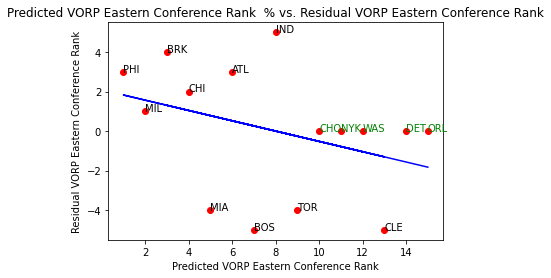

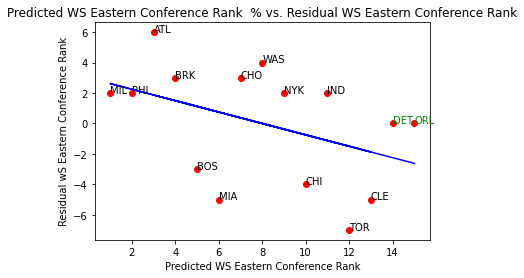

In [1018]:
#creating scatterplot of predicted VORP rank vs residual VORP rank for Eastern Conference

#setting x and y axis
X = easternRankings22["Predicted VORP Conference Rank"]
y = easternRankings22["Residual VORP Rank"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('Predicted VORP Eastern Conference Rank  % vs. Residual VORP Eastern Conference Rank')
plt.xlabel('Predicted VORP Eastern Conference Rank')
plt.ylabel('Residual VORP Eastern Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(easternRankings22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

#creating scatterplot of predicted WS rank vs residual WS rank for Eastern Conference

#setting x and y axis
X = easternRankings22["Predicted WS Conference Rank"]
y = easternRankings22["Residual WS Rank"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('Predicted WS Eastern Conference Rank  % vs. Residual WS Eastern Conference Rank')
plt.xlabel('Predicted WS Eastern Conference Rank')
plt.ylabel('Residual wS Eastern Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(easternRankings22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

We see that both plots are much closer to predicting the actual rankings for teams that have teams that are right in the middle of the pack as this is when the residual is zero. We can see the residual for VORP in the eastern conference does not pass +2 or -2 on either side as well. WS max residuals are wider in these areas.

###### Why are the middle teams so far away from the best fit line?

That is a great question! In this scenario, there are not enough data points in the eastern conference and the correlation is very low in the middle areas where the residuals are supposed to be the lowest. As a result, we will have to look more closely at the data points instead of the line. In the VORP scatterplot, higher rank predicted teams are very far up the graph and they were predicted to be much lower. However, the points in the middle-end area and the end area are very close to zero or at zero. With WS, we can see that the predictions can be as far off as well in the middle section. However, WS does very well in predicting high ranking teams. Both MIL and PHI were not far off from hitting zero on the WS chart. WS does perform well at the other end of the ranking as well, where it got two predictions correct. 


##### Western Conference

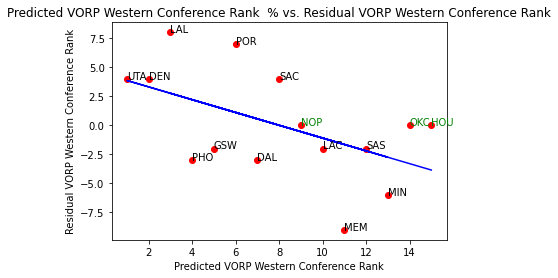

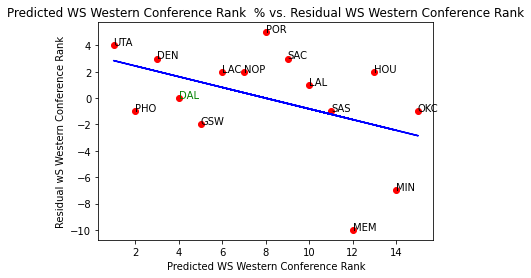

In [1019]:
#creating scatterplot of predicted VORP rank vs residual VORP rank for Western Conference

#setting x and y axis
X = westernRankings22["Predicted VORP Conference Rank"]
y = westernRankings22["Residual VORP Rank"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('Predicted VORP Western Conference Rank  % vs. Residual VORP Western Conference Rank')
plt.xlabel('Predicted VORP Western Conference Rank')
plt.ylabel('Residual VORP Western Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(westernRankings22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

#creating scatterplot of predicted VORP rank vs residual VORP rank for Western Conference

#setting x and y axis
X = westernRankings22["Predicted WS Conference Rank"]
y = westernRankings22["Residual WS Rank"]

#fitting line of best fit
m, b = np.polyfit(X, y, 1)

#plotting and labelling
plt.scatter(X, y, color='red')
plt.plot(X, m*X+b, c = 'b')
plt.title('Predicted WS Western Conference Rank  % vs. Residual WS Western Conference Rank')
plt.xlabel('Predicted WS Western Conference Rank')
plt.ylabel('Residual wS Western Conference Rank')

#putting name of teams next to points
for i, txt in enumerate(westernRankings22["Team"]):
    if y[i] == 0:
        plt.annotate(txt , (X[i], y[i]),color = 'green')
    else:
        plt.annotate(txt , (X[i], y[i]),color = 'black')
plt.show()

Let’s look at the data points again because the lines of best fit are not accurate enough with the number of data points we had. Let’s look at VORP first.

VORP did not perform as well as it did in the Eastern Conference. Its widest residuals were +8 and -8. In this conference, VORP correctly predicted more teams in the middle section very close to where they were supposed to be. Again, VORP poorly predicted the very highly ranked teams. 

WS had a smaller range than VORP in this conference. The highest residuals for WS was +5 and -10. If we don’t count the Memphis Grizzlies(clearly an outlier), then the -10 would fall to just -7. Overall, the WS model undershot many of the teams. Most teams were on top of the zero residual line. In this conference, the WS model also predicted the top ranking teams very well. None of the top 8 predicted were more than 4 off where they were supposed to be. There were some outliers in the mid section, but WS did generally well by placing Sacramento only 3 places away, the Lakers only 1 spot away, and the Spurs 1 spot away.


This is not part of the analysis of models, but it is very interesting to see how both teams did not factor the Grizzlies into the conversation and severely miscalculated on this team! This is most likely due to the Grizzlies having a very young, but talented roster that did not perform well in the 2020-21 NBA season. 

With residuals, we were better able to see which predictor did better in some areas. However, there was no clear winner. To get a better understanding, let’s take a look at the residual values themselves from a statistical standpoint. Here are the average residuals for both models in both conferences. These averages were by first getting the absolute value of the residual to avoid the zero average. 

#### Statistics on Residuals

In [1020]:
#finding average residuals for both models in each conference
#using absolute value so the mean doesn't result in zero

avgEasternVORPResidual = easternRankings22["Residual VORP Rank"].abs().mean()
avgEasternWSResidual = easternRankings22["Residual WS Rank"].abs().mean()

avgWesternVORPResidual = westernRankings22["Residual VORP Rank"].abs().mean()
avgWesternWSResidual = westernRankings22["Residual WS Rank"].abs().mean()

print("The average VORP residual in the Eastern Conference was: " + str(avgEasternVORPResidual))
print("The average WS residual in the Eastern Conference was: " + str(avgEasternWSResidual))
print()
print("The average VORP residual in the Western Conference was: " + str(avgWesternVORPResidual))
print("The average WS residual in the Western Conference was: " + str(avgWesternWSResidual))

The average VORP residual in the Eastern Conference was: 2.4
The average WS residual in the Eastern Conference was: 3.2

The average VORP residual in the Western Conference was: 3.6
The average WS residual in the Western Conference was: 2.933333333333333


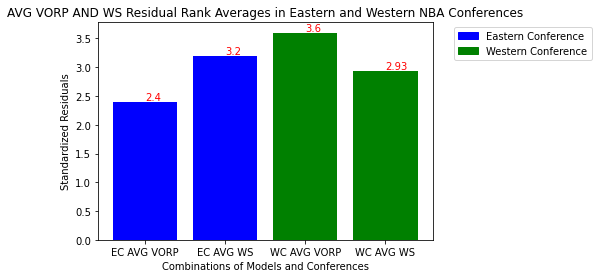

In [1021]:
#creating bar graph

#setting x and y axis
xAxis = ["EC AVG VORP", "EC AVG WS", "WC AVG VORP", "WC AVG WS"]
yAxis = [avgEasternVORPResidual, avgEasternWSResidual, avgWesternVORPResidual, avgWesternWSResidual]

#plotting and labelling
plt.title('AVG VORP AND WS Residual Rank Averages in Eastern and Western NBA Conferences')
plt.xlabel('Combinations of Models and Conferences')
plt.ylabel('Standardized Residuals')
plt.bar(xAxis,yAxis, color=['blue', 'blue', 'green', 'green'])

#creating legend
colors = {'Eastern Conference':'blue', 'Western Conference':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels,bbox_to_anchor=(1.05, 1))

#adding text
for i in range(len(xAxis)):
        plt.text(i,round(yAxis[i],2)+0.03,round(yAxis[i],2),color = 'red')
plt.show()

We can see in the eastern conference, the average residual value for VORP is lower than the average residual value for WS. However, in the western conference, the average residual value for WS was lower than the average residual value for VORP. There is still no clear winner in this situation because one ranking did better than the other in each conference. 

Clearly, there are not enough data points from the 2022 season to make generalizations about VORP and WS. However, we could observe some simple and obvious trends that our predictions gave us.

###### END OF TUTORIAL CASE STUDY

### Applying What We Learned In The Case Study

Let’s jump back to all seasons to gauge both VORP and WS better. First, we’ll split all the seasons by conference. Now, we are going to create a residual column for all seasons by subtracting the predicted rank by both models from the actual rank. At this point, we could find the average residual, but after doing more research it would be better to use standard error metrics such as residual standard deviation. We will use residual standard deviation because this way we can magnify results that were more wrong. By averaging the residuals, we were not punishing larger mistakes harshly enough. We can calculate the residual standard deviation by squaring each residual and then finding the sum of squared residuals. Then we divide by n-2 because we lose 2 degrees of freedom. Now, we are given the residual standard deviation for each model in each conference. 

In [1022]:
#creating Eastern/Western Conference Team Stats Dataframes with all years and 

allEastTeamStats = teamStats.loc[(teamStats["Conference"] == 'East')].reset_index(drop = True)
allWestTeamStats = teamStats.loc[(teamStats["Conference"] == 'West')].reset_index(drop = True)

#adding residual columsn for both models to each dataframe
allEastTeamStats["Residual VORP Rank"] = allEastTeamStats["Actual Conference Rank"] - allEastTeamStats["Predicted VORP Conference Rank"]
allEastTeamStats["Residual WS Rank"] = allEastTeamStats["Actual Conference Rank"] - allEastTeamStats["Predicted WS Conference Rank"]
allWestTeamStats["Residual VORP Rank"] = allWestTeamStats["Actual Conference Rank"] - allWestTeamStats["Predicted VORP Conference Rank"]
allWestTeamStats["Residual WS Rank"] = allWestTeamStats["Actual Conference Rank"] - allWestTeamStats["Predicted WS Conference Rank"]

#computing residual standard deviation for both models from both dataframes
resStdDevEasternVORP = ((allEastTeamStats["Residual VORP Rank"] ** 2).mean())/len(allEastTeamStats["Residual VORP Rank"] - 2)
resStdDevEasternWS = ((allEastTeamStats["Residual WS Rank"] ** 2).mean())/len(allEastTeamStats["Residual WS Rank"] - 2)

resStdDevWesternVORP = ((allWestTeamStats["Residual VORP Rank"] ** 2).mean())/len(allWestTeamStats["Residual VORP Rank"] - 2)
resStdDevWesternWS = ((allWestTeamStats["Residual WS Rank"] ** 2).mean())/len(allWestTeamStats["Residual WS Rank"] - 2)

print("The residual std. dev. in the Eastern Conference for VORP was: " + str(resStdDevEasternVORP))
print("The residual std. dev. in the Eastern Conference for WS was: " + str(resStdDevEasternWS))
print("The residual std. dev. in the Western Conference for VORP was: " + str(resStdDevWesternVORP))
print("The residual std. dev. in the Western Conference for WS was: " + str(resStdDevWesternWS))

The residual std. dev. in the Eastern Conference for VORP was: 0.04937904610912935
The residual std. dev. in the Eastern Conference for WS was: 0.05048553309552121
The residual std. dev. in the Western Conference for VORP was: 0.03520829819531118
The residual std. dev. in the Western Conference for WS was: 0.03925619834710744


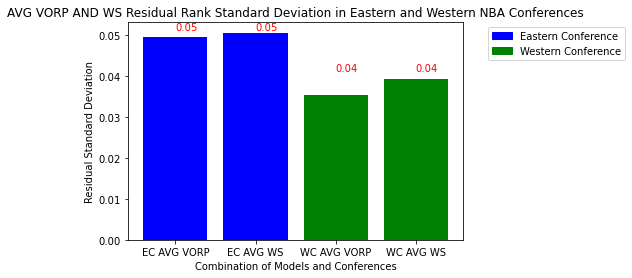

In [1023]:
#creating bar graph

#setting x and y axis
xAxis = ["EC AVG VORP", "EC AVG WS", "WC AVG VORP", "WC AVG WS"]
yAxis = [resStdDevEasternVORP, resStdDevEasternWS, resStdDevWesternVORP, resStdDevWesternWS]

#plotting and labelling
plt.title('AVG VORP AND WS Residual Rank Standard Deviation in Eastern and Western NBA Conferences')
plt.xlabel('Combination of Models and Conferences')
plt.ylabel('Residual Standard Deviation')
plt.bar(xAxis,yAxis, color=['blue', 'blue', 'green', 'green'])

#creating legend
colors = {'Eastern Conference':'blue', 'Western Conference':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.5, 1))

#adding text
for i in range(len(xAxis)):
        plt.text(i,round(yAxis[i],2)+0.001,round(yAxis[i],2),color = 'red')
plt.show()

From the first look, we can see that the standard deviation for both models are much higher in the Eastern conference than the Western conference. With this information, we can say that the standard for error in the Eastern conference is much higher because teams play at much closer levels in the Eastern conference. Whereas in the Western conference, there may not be as much fierce competition at the top of the rankings or at the bottom of the rankings, which makes it easier to rank teams. Basing it off of context, this data makes sense. Within the last 20 years, the Western conference did have the better teams, which probably made it easier to place these teams at the top. In the Eastern conference, there were always only a couple great teams. It might have been simple to place these teams at the top, but it may have been more difficult to rank the rest of the very average teams.

From the residual standard deviations, we also have a clear winner: VORP. VORP did slightly better in ranking in the Eastern conference and had a margin of .04 in the Western conference. Although the competition was very close, VORP did prove to always predict more teams in the Western and Eastern conference in the 2021-22 NBA season.

# Chapter 7: Hypothesis Testing Again

Finally, let's compare VORP and WS with another hypothesis test. This time, let's use rank instead of win percentages. We'll use rank because at the end of the day, the rank is all that matters. More wins = higher rank(closer to one). Less wins = lower rank(closer to the number of teams in a conference, which is 15).

###### VORP Hypothesis:
Ho: The population correlation coefficient between VORP and team rank is not significantly different from zero.

Ha: The population correlation coefficient between VORP and team rank is significantly different from zero.

###### WS Hypothesis:
Ho: The population correlation coefficient between WS and team rank is not significantly different from zero.

Ha: The population correlation coefficient between WS and team rank is significantly different from zero.

Significance level/alpha = 0.05

### MACHINE LEARNING - Linear Regression

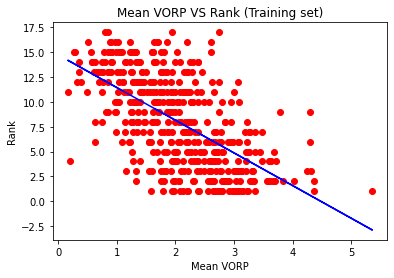

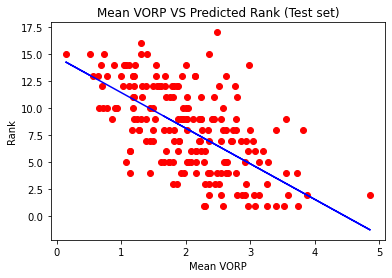

Accuracy of VORP model: 34.000889630384165%
p-value of VORPmodel: 1.53676604373573e-48


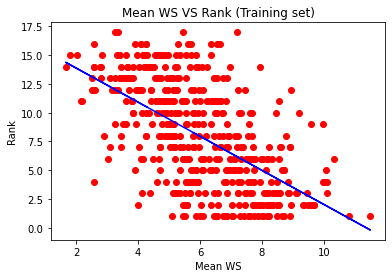

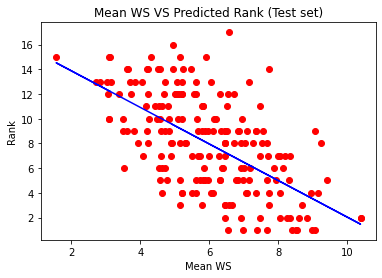

Accuracy of WS model: 35.863282540630294%
p-value of WSmodel: 1.647005698840655e-42


In [1078]:
#pvalues and accuracies list for later use
pValues = []
accuracies = []

#creating graph for VORP and WS. making one graph for each stat. 
for stat in ['VORP','WS']:
    #using linear regression
    regressor = linear_model.LinearRegression()
    
    #setting x and y axis
    X = teamStats["Mean " + stat]
    y = teamStats["Actual Conference Rank"]
    
    #splitting into testing and training set. making the testing set 30% of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    #reshaping for fit/predict functions
    X_train= X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    
    #getting the model
    regressor.fit(X_train, y_train)
    
    #getting p-value
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    pValues.append(est2.pvalues[1])
    
    #plotting the model on the training data
    plt_train = plt
    plt_train.scatter(X_train, y_train, color='red')
    plt_train.plot(X_train, regressor.predict(X_train), color='blue')
    plt_train.title('Mean '+ stat + ' VS Rank (Training set)')
    plt_train.xlabel('Mean ' + stat)
    plt_train.ylabel('Rank')
    plt_train.show()
    
    #plotting the model on the testing data
    plt_test = plt
    plt_test.scatter(X_test, y_test, color='red')
    plt_test.plot(X_test, regressor.predict(X_test), color='blue')
    plt_test.title('Mean '+ stat + ' VS Predicted Rank (Test set)')
    plt_test.xlabel('Mean ' + stat)
    plt_test.ylabel('Rank')
    plt_test.show()
    
    #predicting win % based on test set for statistic
    y_pred = regressor.predict(X_test)
    
    #determine accuracy
    accuracy = regressor.score(X_test,y_test)* 100
    accuracies.append(accuracy)
    print("Accuracy of " + stat + " model: " + str(accuracy) + "%")    
    print("p-value of " + stat + "model: " + str(est2.pvalues[1]))


In [1077]:
print("Accuracy of VORP model: " + str(accuracies[0]) + "%")    
print("p-value of VORP model: " + str(pValues[0]))
print()
print("Accuracy of WS model: " + str(accuracies[1]) + "%")    
print("p-value of WS model: " + str(pValues[1]))
print()

Accuracy of VORP model: 34.000889630384165%
p-value of VORP model: 1.53676604373573e-48

Accuracy of WS model: 35.863282540630294%
p-value of WS model: 1.647005698840655e-42



The p-value of both models are extremely small and much smaller than our significance level of 0.05. As a result, we can reject the null hypothesis and can conclude that the population correlation coefficient between WS and team rank and the population correlation coefficient between VORP and team rank is significantly different from zero. 

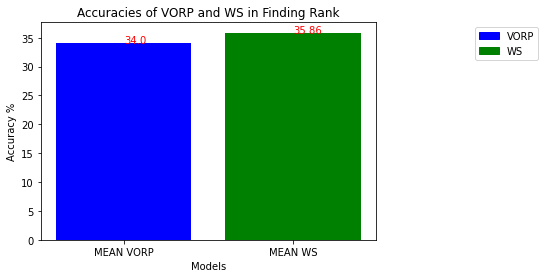

In [1076]:
#creating bar graph

#setting x and y axis
xAxis = ["MEAN VORP","MEAN WS"]
yAxis = accuracies

#plotting and labelling
plt.title('Accuracies of VORP and WS in Finding Rank')
plt.xlabel('Models')
plt.ylabel('Accuracy %')
plt.bar(xAxis,yAxis, color=['blue', 'green'])

#creating legend
colors = {'VORP':'blue', 'WS':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.5, 1))

#adding text
for i in range(len(xAxis)):
        plt.text(i,round(yAxis[i],2)+0.001,round(yAxis[i],2),color = 'red')
plt.show()

For the accuracies, the WS was much better than the VORP model. It shows how close WS and VORP are close to each other. However, we can still conclude that VORP is still a better model because it is much more significant than WS. VORP also has the better result in most of the tests we have conducted so far.

However, something weird we see is that the accuracies for rank are smaller than the accuracies for win percentage. What might contribute to this is that there is a less direct relationship between rank and these advanced statistics. Winning % has a more direct relationship because it almost completely depends on how individuals on the team does. The Rank depends more on how other teams do as well.

# Chapter 8: Conclusions / Insights

Just looking at the data and charts, the advanced statistic that best predicted the NBA records was Value Over Replacement Player(VORP). VORP is a way to measure how many more points a player could score versus a replacement/bench player in the same situation. VORP is a highly coveted advanced statistic used throughout many sports today. An example of a player with an extremely high VORP from this year’s season is actually Nikola Jokic, this year’s Most Valuable Player. His VORP was an outrageously high, 9.8 and is 14th highest all time for a single season(MJ and Lebron are 1 and 2). Win Shares(WS) was another great way to measure how well teams did although it wasn’t as good of a metric as VORP. WS performed very closely and consistently next to VORP, but always did not measure as well. The correlation coefficient of WS was higher in our first exploratory analysis, but after looking at the number of teams VORP predicted correctly in the case study, the lower residual standard deviation, the higher accuracy in our linear regression, and lower p-value, we can safely conclude that VORP is the better metric to predict NBA rankings and record. The other metrics were nowhere close to VORP and WS in terms of p-value, accuracy, and correlation coefficient. If there were a second tier of indicators it would include BPMand WS/48. These statistics had p-values below the 0.05 threshold and positive accuracies with accuracies of 12.44% and 8.71% respectively. TS% did have a p-value lower than the threshold, but its accuracy was in the negatives, so it was not as reliable. Both the TRB% and AST% statistics were above the p-value threshold, were not statistically significant, and as a result was less reliable. 

However, it is also important to consider the context of these situations! These calculations were based before the season started and it factored in many assumptions. There are countless injuries happening in the NBA every year, it is highly possible a highly ranked player got injured. Rookies were not included either. Although there is a very low possibility a rookie comes onto a team and completely changes the face of the team, there are always scenarios where this has happened. The most memorable of these scenarios was Magic Johsnon stepping in for Hall-of-Famer Kareem Abdul-Jabbar, and winning the entire championship. Another factor this method does not include is breakout players. Each year, players that have not played well the year before have done outstandingly well. This season’s most improved players include Ja Morant, Marcus Smart, Dejounte Murray, Darius Garland, Jordan Poole, and much more. Any teams with these players would have overperformed according to predictions. In fact, the most improved player, Ja Morant, was the star player of the Memphis Grizzlies in the 2021-2022 NBA season. This team was also the outlier we saw in the case study, so it is evident that this scenario can occur frequently. Lastly, a possible scenario is a change of coaching. Coaching can always make or break a season for any team. For future steps, we could try updating the rosters every match to account for advanced stats from games played the same season. We could also try taking the average of the entire team, instead of just the top 5. If a team has good depth(meaning that they have many above-average players instead of just a couple great players), then the strategy of using the top 5 players would not have been sufficient. Overall, one statistic is not enough to make an accurate prediction for the overall NBA record. There are simply too many factors to account to simply use one statistic. A better method would be to update the roster’s advanced stats as the season plays on and finding more correlations between win percentages and the roster’s statistics.


## References:

https://www.basketball-reference.com/

https://bleacherreport.com/articles/1813902-advanced-nba-stats-for-dummies-how-to-understand-the-new-hoops-math

https://www.investopedia.com/terms/r/residual-standard-deviation.asp

https://towardsdatascience.com/p-values-and-when-not-to-use-them-92cab8a86304

https://datagy.io/python-pearson-correlation/